<a href="https://colab.research.google.com/github/benbatman/Classification_Neural_Networks/blob/main/PyTorch_Classification_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Classification Practice 

- A Colab notebook to practice with the PyTorch API

In [47]:
import torch
print(torch.__version__)

1.12.1+cu113


In [48]:
import requests
from pathlib import Path 

# Get two helper functions from ZTM Academy 
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [49]:
from sklearn.datasets import make_moons

# 1000 samples 
n_samples = 1000

# Make the moons 
X, y = make_moons(n_samples, noise=0.1,
                  random_state=42)

In [50]:
# Examine features and labels
# Binary classification
X[:10], y[:10]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665],
        [ 0.61370557, -0.24236929],
        [ 0.2864947 , -0.20127661],
        [-0.05610416,  0.4770791 ],
        [ 1.60421687, -0.30354141],
        [ 0.70964149,  0.85886674]]), array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [51]:
# Make a DataFrame of the moon data 
import pandas as pd 
moons = pd.DataFrame({"X0": X[:,0],
                      "X1": X[:,1],
                      "labels": y})
moons.head()

,X0,X1,labels
0,-0.051470,0.444199,1
1,1.032017,-0.419741,1
2,0.867892,-0.254827,1
3,0.288851,-0.448669,1
4,-0.833439,0.535057,0


In [52]:
# Check different lbaels 
moons.labels.value_counts()

1    500
0    500
Name: labels, dtype: int64

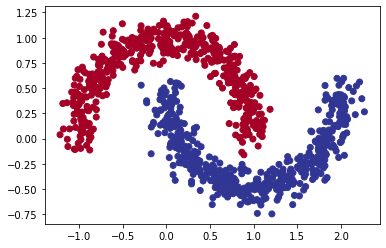

In [53]:
# Plot our data 
import matplotlib.pyplot as plt 

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [54]:
# Check shapes 
X.shape, y.shape

((1000, 2), (1000,))

In [55]:
# Turn our data into tensors 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0515,  0.4442],
         [ 1.0320, -0.4197],
         [ 0.8679, -0.2548],
         [ 0.2889, -0.4487],
         [-0.8334,  0.5351]]), tensor([1., 1., 1., 1., 0.]))

In [56]:
# Split the data into training and test sets 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=7)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building the model 

In [57]:
from torch import nn 

# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [58]:
# Build the model 
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=32)
    self.layer_2 = nn.Linear(in_features=32, out_features=32)
    self.layer_3 = nn.Linear(in_features=32, out_features=16)
    self.layer_4 = nn.Linear(in_features=16, out_features=1) # output feature should be 1 as binary classification 
    self.relu = nn.ELU() # our activation function

  # Define the forward pass
  def forward(self, x):
    return self.layer_4(self.relu(self.layer_3(self.layer_2(self.layer_1(x)))))

model_0 = MoonModel().to(device)
print(model_0)

MoonModel(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ELU(alpha=1.0)
)


In [59]:
model_0.parameters

<bound method Module.parameters of MoonModel(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ELU(alpha=1.0)
)>

In [60]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [61]:
# Create accuracy function 
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100 
  return acc 

In [62]:
# Fit the model 
torch.manual_seed(7)
epochs = 1000 

# Put data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # 1. Forward pass 
  y_logits = model_0(X_train).squeeze() # raw outputs of model
  y_pred = torch.round(torch.sigmoid(y_logits)) # apply sigmoid function

  # 2. Calculate loss and accuracy 
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, 
                         y_pred=y_pred)
  
  # 3. Optimizer zero grad 
  optimizer.zero_grad()

  # 4. Loss backwards 
  loss.backward()

  # 5. optimizer.step()
  optimizer.step()

  ### Testing 
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass 
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Loss and accuracy 
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.65967, Accuracy: 77.25% | Test loss: 0.65122, Test Accuracy: 76.50%
Epoch: 100 | Loss: 0.24755, Accuracy: 88.12% | Test loss: 0.29189, Test Accuracy: 86.50%
Epoch: 200 | Loss: 0.24409, Accuracy: 88.00% | Test loss: 0.28842, Test Accuracy: 86.50%
Epoch: 300 | Loss: 0.24235, Accuracy: 88.00% | Test loss: 0.28655, Test Accuracy: 86.50%
Epoch: 400 | Loss: 0.24195, Accuracy: 88.00% | Test loss: 0.28639, Test Accuracy: 86.50%
Epoch: 500 | Loss: 0.23997, Accuracy: 87.88% | Test loss: 0.28481, Test Accuracy: 86.50%
Epoch: 600 | Loss: 0.21992, Accuracy: 88.88% | Test loss: 0.26348, Test Accuracy: 84.50%
Epoch: 700 | Loss: 0.07600, Accuracy: 98.00% | Test loss: 0.08901, Test Accuracy: 97.50%
Epoch: 800 | Loss: 0.01748, Accuracy: 99.75% | Test loss: 0.01966, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01082, Accuracy: 99.88% | Test loss: 0.01113, Test Accuracy: 100.00%


In [63]:
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0.]),
 tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0.]))

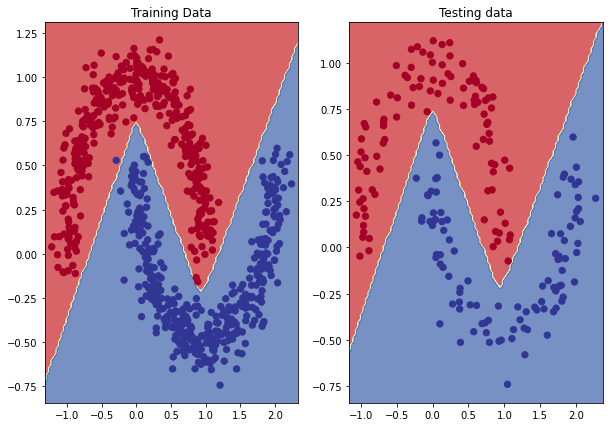

In [64]:
# Plot decision boundaries for training and test sets 
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Training Data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Testing data")
plot_decision_boundary(model_0, X_test, y_test)

In [65]:
!pip -q install torchmetrics 

from torchmetrics import Accuracy 
# Setup metric and make sure it's on target device 
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy 
torchmetrics_accuracy(y_preds,y_test.type(torch.long))

tensor(1.)

### Multi-class Classification Model 

In [66]:
import requests
from pathlib import Path 

# Get two helper functions from ZTM Academy 
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

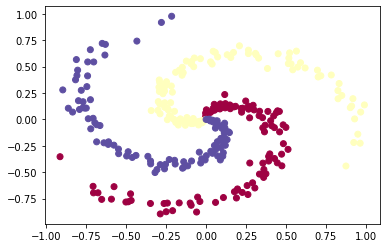

In [67]:
# Code for creating spiral dataset form CS231n 
import numpy as np
import matplotlib.pyplot as plt 
N = 100 # number of points per class 
D = 2 # dimensionality 
K = 3 # number of classes 
X = np.zeros((N*K, D))
y = np.zeros(N*K, dtype='uint8') # data matrix (each row = single example)

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j


# Visualize the data 
plt.scatter(X[:, 0], X[:,1], c=y, cmap=plt.cm.Spectral)
plt.show()

In [68]:
X.shape, y.shape

((300, 2), (300,))

In [69]:
# One sample
X[:10], y[:10]

(array([[-0.        ,  0.        ],
        [ 0.00191257,  0.00991829],
        [-0.00260755,  0.02003303],
        [-0.00076309,  0.03029342],
        [-0.00066776,  0.04039852],
        [ 0.00459452,  0.05029563],
        [-0.0029696 ,  0.06053326],
        [ 0.02628071,  0.06564156],
        [ 0.03148107,  0.07442371],
        [ 0.00181292,  0.09089101]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [70]:
import torch
from torch import nn 

# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [71]:
# Turn the data into tensors 
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
type(X), X.dtype, type(y), y.dtype

(torch.Tensor, torch.float32, torch.Tensor, torch.float32)

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=7)
len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

In [73]:
# Constans 
NUM_CLASSES = K
NUM_FEATURES = D

In [74]:
# Build the model 
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=32):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_stack(x)
  
# Create instnace of SpiralModel and send it to the target device 
model_1 = SpiralModel(input_features=NUM_FEATURES,
                      output_features=NUM_CLASSES,
                      hidden_units=32).to(device)

model_1

SpiralModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [75]:
# Create loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.01)

In [76]:
# Let's do a single forward pass on the data 
model_1(X_train.to(device))[:5]

tensor([[-0.0263, -0.0042, -0.1458],
        [-0.0039,  0.0057, -0.1359],
        [-0.0040,  0.0069, -0.1397],
        [-0.0025,  0.0070, -0.1357],
        [-0.0106,  0.0011, -0.1407]], grad_fn=<SliceBackward0>)

In [77]:
model_1(X_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([3]), 3)

In [78]:
# Fit the model
torch.manual_seed(7)

# Number of epochs 
epochs = 100

# Put data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training 
  model_1.train()

  # 1 Forward pass 
  y_logits = model_1(X_train) # Outputs raw logits 
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1), # logits to probabilities

  # 2. Calculate loss and accuracy 
  loss = loss_fn(y_logits, y_train.type(torch.long))
  accuracy = accuracy_fn(y_true=y_train, 
                         y_pred=y_pred[0]) # y_pred is a tuple, so index on the first element
  
  # 3. Optimizer zero grad 
  optimizer.zero_grad()

  # 4. Loss backwards 
  loss.backward()

  # 5. Optimizer step 
  optimizer.step()

  ### Testing 
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass 
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate loss and accuracy 
    test_loss = loss_fn(test_logits, y_test.type(torch.long)) 
    test_acc = accuracy_fn(y_true=y_test, 
                           y_pred=test_pred)
    
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.10049, Acc: 32.92% | Test Loss: 1.09238, Test Acc: 53.33%
Epoch: 10 | Loss: 0.88639, Acc: 62.50% | Test Loss: 0.74783, Test Acc: 76.67%
Epoch: 20 | Loss: 0.54887, Acc: 69.58% | Test Loss: 0.39240, Test Acc: 78.33%
Epoch: 30 | Loss: 0.23880, Acc: 93.33% | Test Loss: 0.21157, Test Acc: 90.00%
Epoch: 40 | Loss: 0.09784, Acc: 97.50% | Test Loss: 0.12494, Test Acc: 95.00%
Epoch: 50 | Loss: 0.05179, Acc: 99.17% | Test Loss: 0.09416, Test Acc: 95.00%
Epoch: 60 | Loss: 0.03633, Acc: 99.17% | Test Loss: 0.06633, Test Acc: 100.00%
Epoch: 70 | Loss: 0.02956, Acc: 99.17% | Test Loss: 0.05709, Test Acc: 100.00%
Epoch: 80 | Loss: 0.02607, Acc: 99.17% | Test Loss: 0.04998, Test Acc: 100.00%
Epoch: 90 | Loss: 0.02410, Acc: 99.17% | Test Loss: 0.04337, Test Acc: 100.00%


In [79]:
# Make predictions 
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)

# First 10 predictions 
y_logits[:10]

tensor([[ -1.6617,  -1.9745,   8.2391],
        [ 13.9619,   5.4982, -12.6504],
        [ -0.6323,   6.5742,  -2.0701],
        [ 10.3194,  -2.1114,  -2.0554],
        [ -1.8072,   7.7183,  -2.4284],
        [-16.1143,   5.6609,  13.0354],
        [  1.3637,  -1.1001,   4.5449],
        [ -3.5265,  -1.8245,   9.8017],
        [ 13.9815,   2.6217,  -9.5405],
        [ 15.9558,  26.2370, -34.5622]])

In [80]:
# Turn predicted logits into prediction probabilities 
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilites into prediction labels 
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels 
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}")

Predictions: tensor([2, 0, 1, 0, 1, 2, 2, 2, 0, 1])
Labels: tensor([2., 0., 1., 0., 1., 2., 2., 2., 0., 1.])
Test accuracy: 100.0


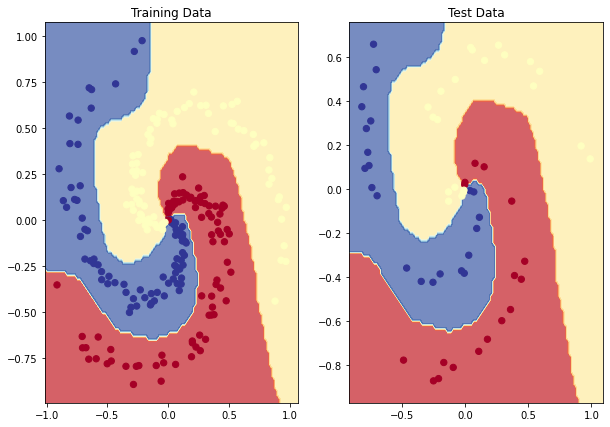

In [81]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title("Training Data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test Data")
plot_decision_boundary(model_1, X_test, y_test)

In [82]:
!pip -q install torchmetrics

from torchmetrics import Accuracy 

# Setup metric and make sure it's on the target device 
torchmetrics_accuracy = Accuracy().to(device) 

# Calculate accuracy 
torchmetrics_accuracy(y_preds, y_test.type(torch.long))

tensor(1.)